In [58]:
#Distance approach
    #Select pairs based on Euclidean distance
    #Pairs formation includes 3 steps
        #1. Normalisation of input data
        #2. Pairs selection
        #3. Calculating historical volatililty

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# Select a wide range of assets you're interested in
assets = ['ES=F', 'CL=F', 'GC=F', 'SI=F', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 
          'JPM', 'V', 'PG', 'XOM', 'GLD', 'SLV', 'USO', 'SPY', 'TLT', 'QQQ', 'DIA', 
          'NFLX', 'TSLA', 'BA', 'KO', 'DIS', 'PLUG', 'GS', 'IBM', 'INTC', 'ORCL', 'NVDA']

start_date = '2000-01-01'
end_date = '2021-12-31'

# Fetch the data for all assets
asset_data = []
asset_dict = {}
for i,  asset in enumerate(assets):
    try:
        df = yf.download(asset, start=start_date, end=end_date)
        if not df.empty:  # If df is not empty
            df = df.resample('B').mean().fillna(method='ffill')  # Resample at daily frequency
            asset_data.append(df['Adj Close'])
            asset_dict[asset] = i
    except Exception as e:
        print(f"Failed to download {asset}: {str(e)}")        

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [59]:
# Testing period
test_start = '2000-01-01'
test_end = '2020-12-31'

def euclidean_distance(p, q):
    return np.sqrt(np.sum(p - q)**2)

# Perform analysis on each asset pair and select the pairs
selected_pairs = []
# Set a distance threshold
distance_threshold = 1
for i in range(len(asset_data)):
    for j in range(i+1, len(asset_data)):
        asset1 = asset_data[i].loc[test_start:test_end]
        asset2 = asset_data[j].loc[test_start:test_end]
        # Check for NaN or missing values in asset1 and asset2
        if asset1.isnull().any() or asset2.isnull().any():
            continue

        # Remove negative values if any (negative values can't be used in log transformation)
        asset1 = asset1[asset1 > 0]
        asset2 = asset2[asset2 > 0]
        
        asset1 = np.log(asset1) # calculate returns
        asset2 = np.log(asset2) # calculate returns

        # Normalise the input data
        asset1 = (asset1 - min(asset1))/ (max(asset1) - min(asset1))
        asset2 = (asset2 - min(asset2))/ (max(asset1) - min(asset1))

         # Ensure asset1 and asset2 have the same length
        min_len = min(len(asset1), len(asset2))
        asset1 = asset1[:min_len]
        asset2 = asset2[:min_len]

        # Calculate euclidean distance
        distance = euclidean_distance(asset1, asset2)

        # Select the pair if the distance is less than the threshold
        if distance < distance_threshold:
            selected_pairs.append((assets[i], assets[j], distance))

# Sort the filtered pairs based on distance in descending order
selected_pairs.sort(key=lambda x: x[2], reverse=False)
for i, pair in enumerate(selected_pairs):
    print(f"Pair {i+1}: {pair[0]} and {pair[1]} with Euclidean distance {pair[2]}")

Pair 1: SPY and TSLA with Euclidean distance 0.05317001146878908
Pair 2: DIA and TSLA with Euclidean distance 0.22558217771407196
Pair 3: QQQ and TSLA with Euclidean distance 0.35899322587328136
Pair 4: MSFT and TSLA with Euclidean distance 0.48115619557938055


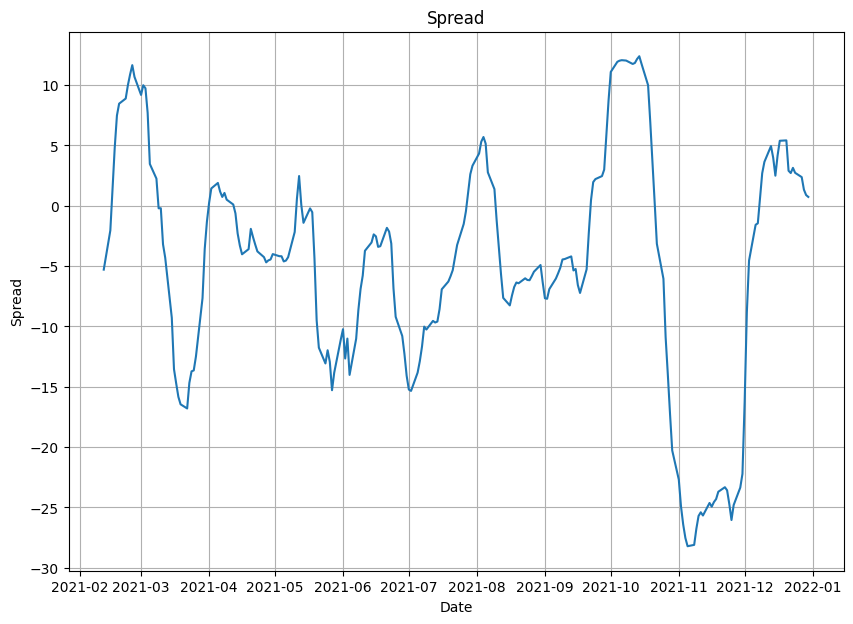

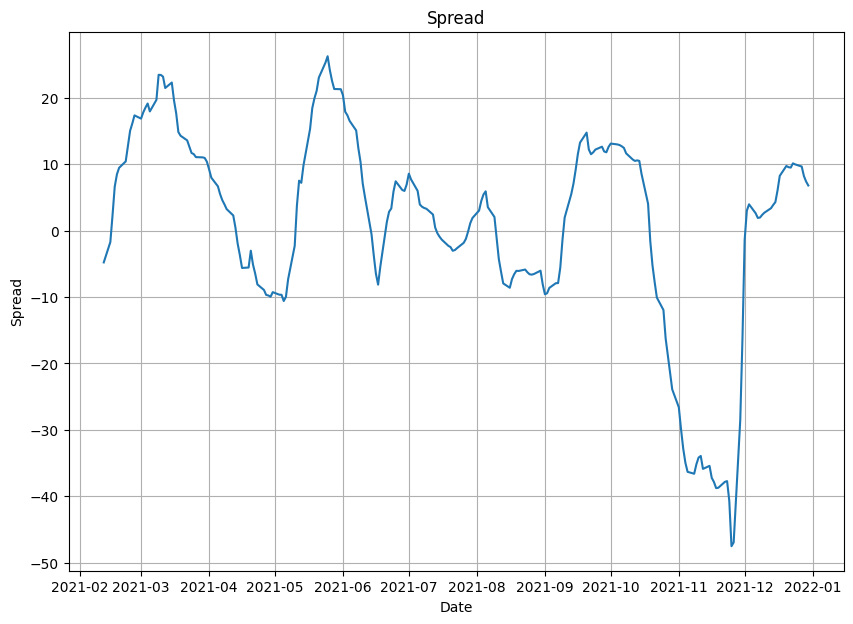

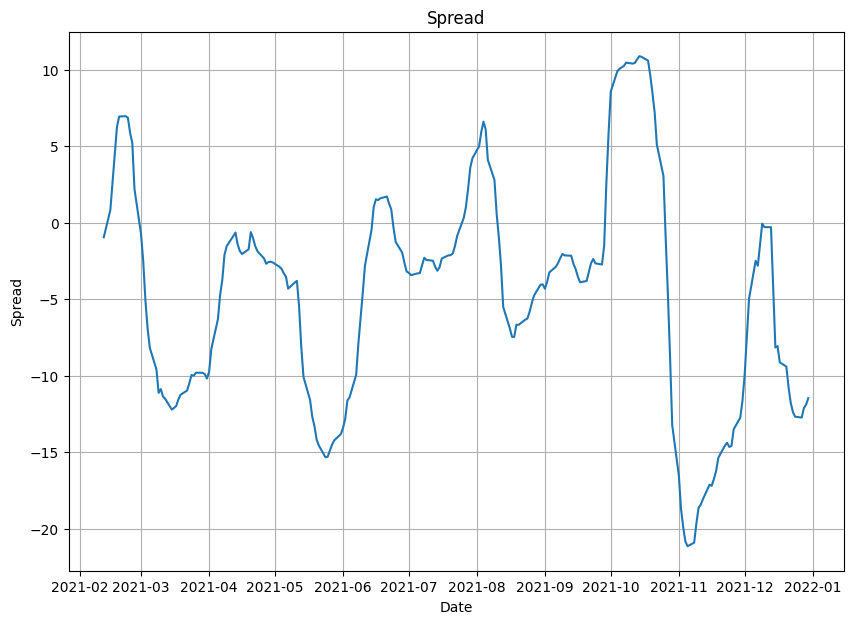

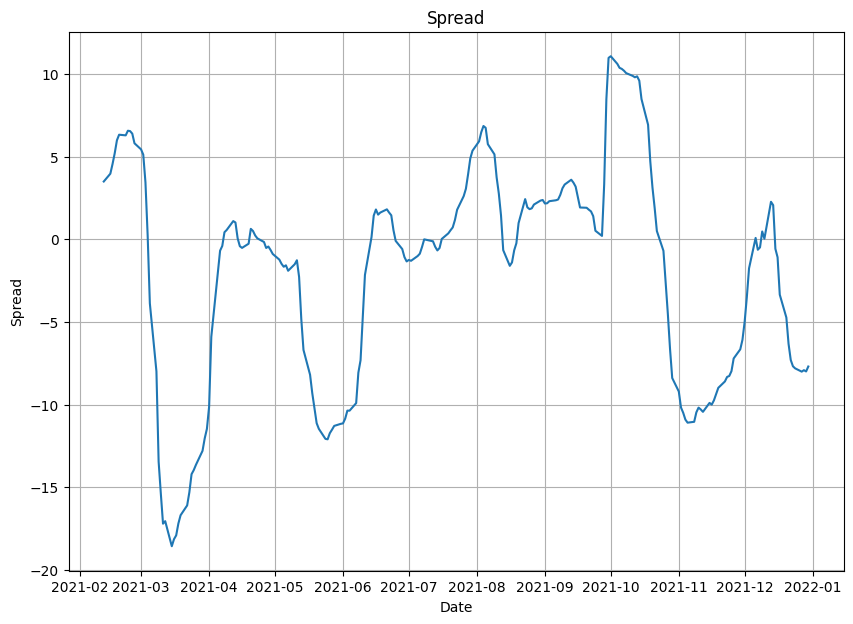

In [60]:
#Apply trading period
start_date = pd.Timestamp("2021-01-01")
end_date = pd.Timestamp("2021-12-31")
sharpe_ratios = []
#Step 2: Compute and standardise the spread
for asset1, asset2, distance in selected_pairs:    
    # Get the returns of the trading period
    asset1_trade = asset_data[asset_dict[asset1]].loc[start_date:end_date]
    asset2_trade = asset_data[asset_dict[asset2]].loc[start_date:end_date]
    asset1_trade = np.log(asset1_trade)
    asset2_trade = np.log(asset2_trade)
    min_len = min(len(asset1_trade), len(asset2_trade))
    asset1_trade = asset1_trade[:min_len]
    asset2_trade = asset2_trade[:min_len]

    #add rolling window
    # Compute spread during the testing period
    window_size = 30
    hedge_ratios = []
    model = LinearRegression()
    #Adding rolling regression
    for i in range(window_size, len(asset1_trade)):
        x = asset1_trade.iloc[i-window_size:i].values.reshape(-1,1)  # reshape for sklearn compatibility
        y = asset2_trade.iloc[i-window_size:i]
        model.fit(x, y)
        hedge_ratios.append(model.coef_[0])
        # Now hedge_ratios contains the coefficient of each window
    hedge_ratios = pd.Series(hedge_ratios, index=asset1_trade.index[window_size:])
   
    spread = (asset1_trade - hedge_ratios * asset2_trade)
    # Plot the spread
    plt.figure(figsize=(10,7))
    plt.plot(spread.index, spread.values)
    plt.title('Spread')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.grid(True)
    plt.show()
    #Rolling window for mean and std
    spread_mean = spread.rolling(25).mean().dropna()
    spread_std = spread.rolling(25).std().dropna()
    z_score = (spread - spread_mean) / spread_std

    # Generate trading strategy
    entry_threshold = 1.0
    exit_threshold = 0.0
    longs = (z_score <= -entry_threshold)
    shorts = (z_score >= entry_threshold)
    exits = ((z_score <= exit_threshold) & shorts) | ((z_score >= -exit_threshold) & longs)
    positions = pd.Series(data=0, index=longs.index)
    positions[longs] = 1
    positions[shorts] = -1
    positions[exits] = 0
    positions = positions.fillna(method='ffill')

    model = LinearRegression()
    model.fit(asset1_trade.values.reshape(-1,1), asset2_trade)
    hedge_ratio = model.coef_[0]
    spread_returns = (asset1_trade - hedge_ratio * asset2_trade)
    min_len = min(len(spread_returns), len(positions))
    spread_returns = spread_returns[:min_len]
    positions = positions[:min_len]
    daily_returns = positions.shift(2) * spread_returns
    daily_std = daily_returns.std()
    #Added epislon value, e, due to some std values being very small/close to 0
    e = 1e-8
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / (daily_std + e)
    sharpe_ratios.append(sharpe_ratio)


In [61]:
# Print and plot the top 20 pairs
for i, (asset1, asset2, distance) in enumerate(selected_pairs):
    sharpe_ratio = sharpe_ratios[i]
    print(f"Pair {i+1}: {asset1}, {asset2}, Sharpe Ratio: {sharpe_ratio}, Euclidean Distance: {distance}")

Pair 1: SPY, TSLA, Sharpe Ratio: 1.1845867673648356, Euclidean Distance: 0.05317001146878908
Pair 2: DIA, TSLA, Sharpe Ratio: 1.348487704496846, Euclidean Distance: 0.22558217771407196
Pair 3: QQQ, TSLA, Sharpe Ratio: 1.8678085620167706, Euclidean Distance: 0.35899322587328136
Pair 4: MSFT, TSLA, Sharpe Ratio: -1.7449414505963972, Euclidean Distance: 0.48115619557938055


In [62]:
#From results, best-performing pair is TSLA and QQQ with sharpe ratio of 1.87
#Limitations:
    #Short Selling: The strategy assumes that you can short any asset.
    #Transaction cost: The strategy does not take into account transaction costs